# COVID-19 LLM Feature Importance Visualization

The purpose of this notebook/script is to load our 120 (currently have 80/120) JSON files generated by the 3 LLMs for prompt engineering comparison, extracting feature importance weights, and visualizing trends across gender distributions, targets, and models.


In [2]:
#plotly import needs nbformat for inline visualization in jupyter notebook
! pip install nbformat




[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Imports
import pandas as pd
import os
import json
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import nbformat

In [5]:
# Load JSON files into DataFrame

#replace w unique path, my cloned repo is in a diff folder rn..
json_dir = r'C:\Users\nehan\Documents\GT\CS 4641\ML_vs_LLM_COVID_GenderBias\Feature Importance Output Files'
json_files = glob.glob(f"{json_dir}/*.json")

all_data = []

for filepath in json_files:
    filename = os.path.basename(filepath)
    llm, cotr, gender_dist, target = filename.replace(".json", "").split("_")

    with open(filepath, 'r') as f:
        feature_weights = json.load(f)

    for feature, weight in feature_weights.items():
        all_data.append({
            "LLM": llm,
            "COTR": cotr,
            "GenderDistribution": gender_dist,
            "Target Value": target,
            "Feature": feature,
            "Importance": weight
        })

df = pd.DataFrame(all_data)

df["LLM"].value_counts() #checking equal distribution of llms

df["Target Value"] = df["Target Value"].str.lower() #The naming method is inconsistent in capitalization (fix later)
df.head(2000) #shows the first 2000 rows 

#Fixing another naming inconsistency with Immunsupr / inmsupr columns
df["Feature"] = df["Feature"].replace({"Immunsupr": "Inmsupr"}) 
print(sorted(df["Feature"].unique()))

['Age', 'Asthma', 'COPD', 'Cardiovascular', 'Diabetes', 'Hypertension', 'ICU', 'Inmsupr', 'Intubed', 'Medical unit', 'Obesity', 'Other disease', 'Patient Type', 'Pregnancy', 'Renal chronic', 'Sex', 'Tobacco', 'Usmr']


### Heatmap of Feature Importance Averages


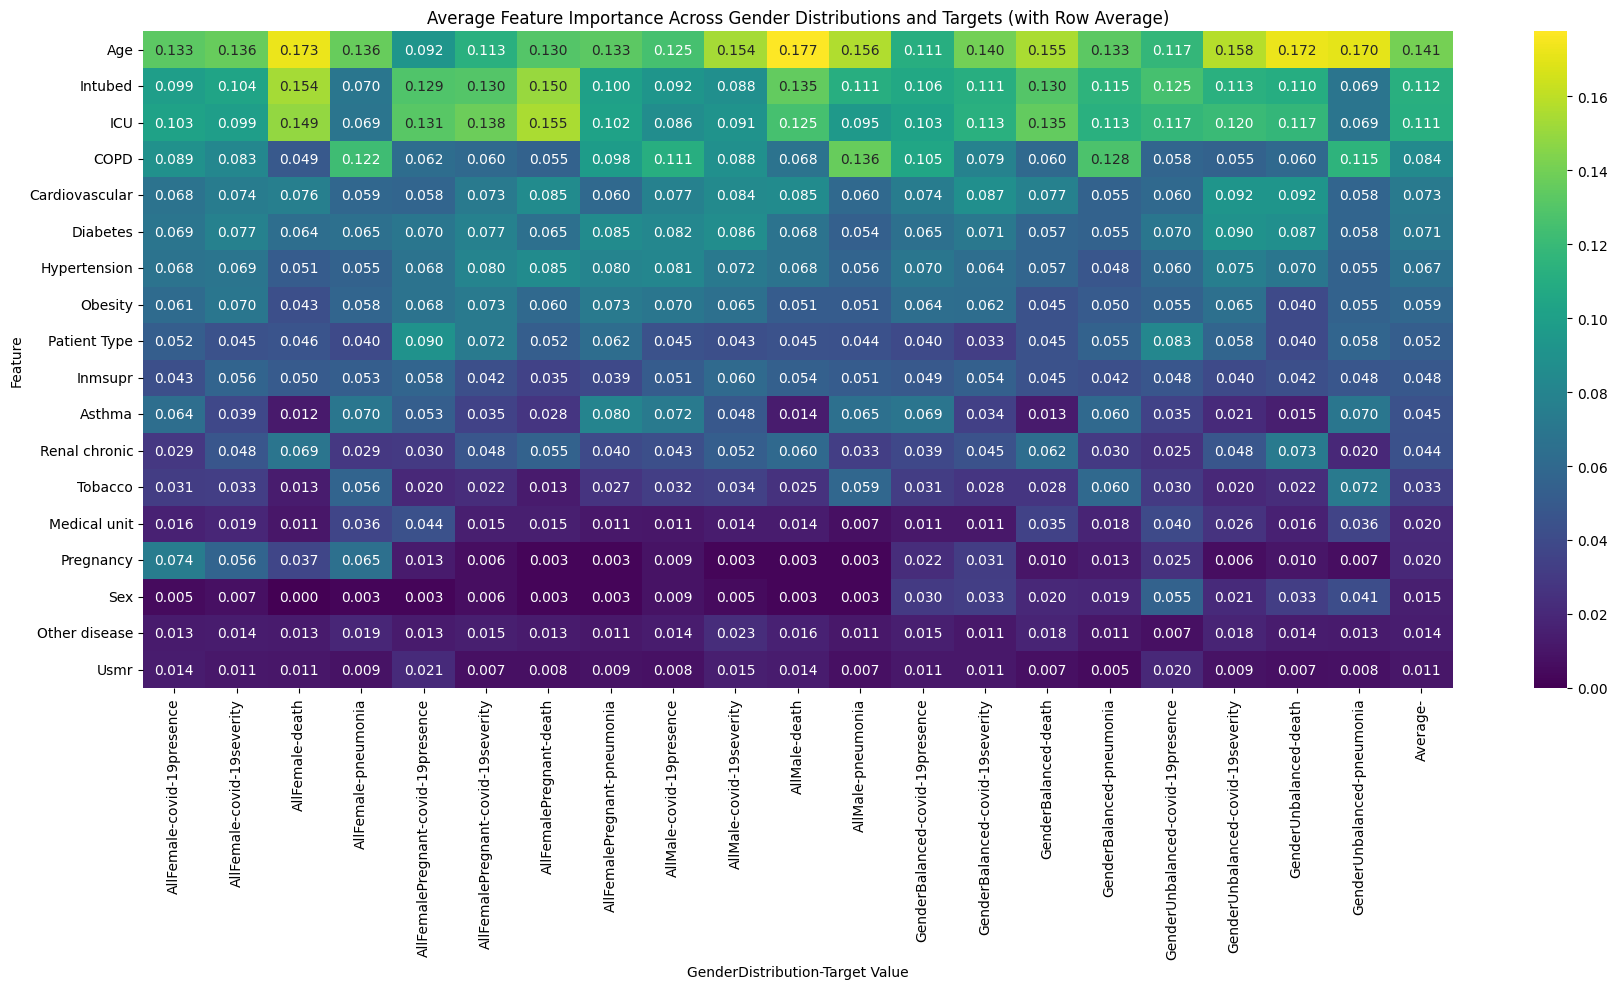


🔝 Top 5 Most Important Features (by Average Importance Across All Conditions):

Feature
Age               0.140688
Intubed           0.112025
ICU               0.111425
COPD              0.083975
Cardiovascular    0.072712
Name: Average, dtype: float64


In [ ]:
# Create pivot table: Feature × (GenderDistribution + Target)
pivot = df.pivot_table(
    values="Importance",
    index="Feature",
    columns=["GenderDistribution", "Target Value"],
    aggfunc="mean"
)

# Calculate average feature importance across all gender/target combos
pivot["Average"] = pivot.mean(axis=1)

# Sort by average (optional: to get most important features at top)
pivot_sorted = pivot.sort_values(by="Average", ascending=False)

#Heatmap of feature importance averages 
plt.figure(figsize=(18, 10))
sns.heatmap(pivot_sorted, annot=True, cmap="viridis", fmt=".3f")
plt.title("Average Feature Importance Across Gender Distributions and Targets (with Row Average)")
plt.tight_layout()
plt.show()

# Print top 5 most important features based on row average
top_5 = pivot_sorted["Average"].head(5)
print("\nTop 5 Most Important Features (by Average Importance Across All Conditions):\n")
print(top_5)

### Average Feature Importance ACROSS ALL OUTPUT COLUMNS/LLMS by Gender Distribution


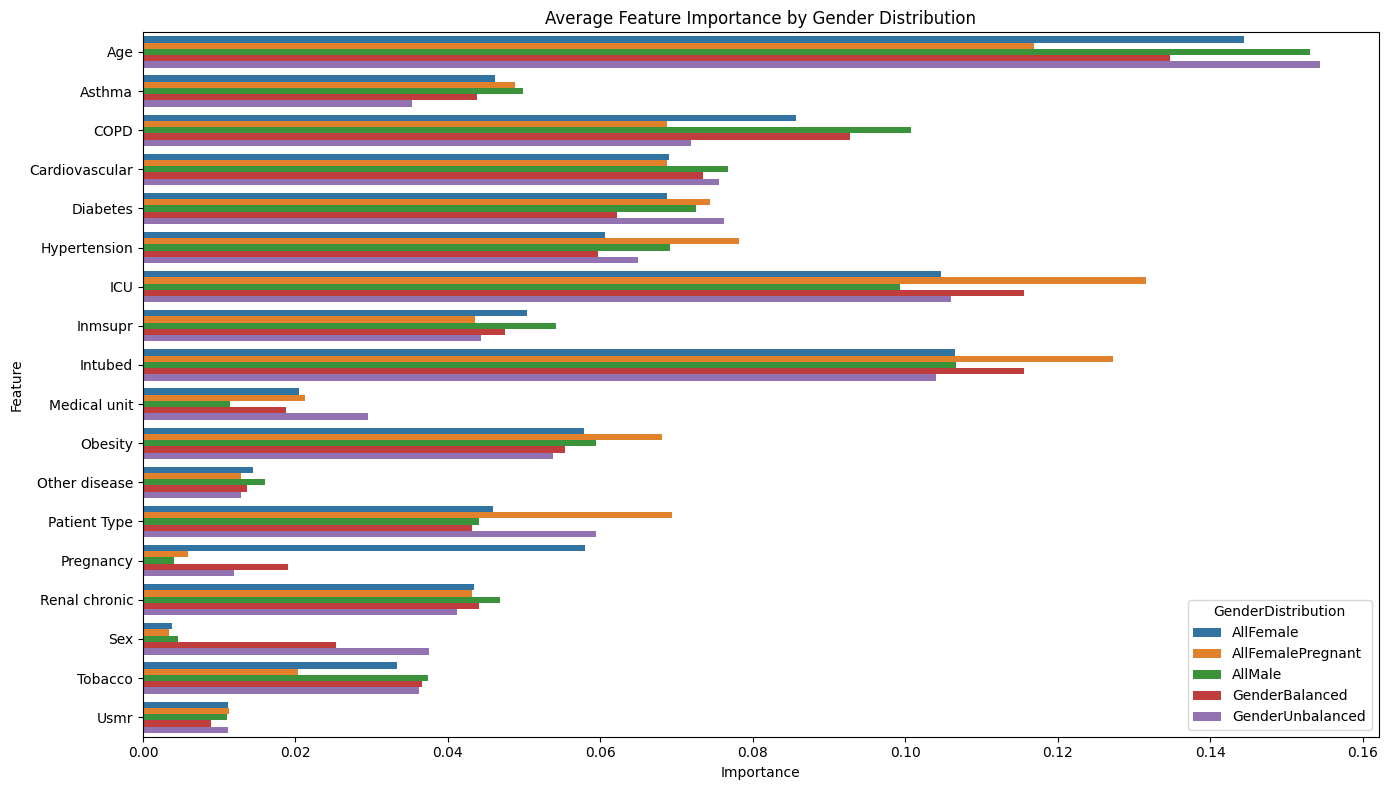

In [8]:
#Bar Graph: Average Feature Importance by Gender Distribution

# Group and average by GenderDistribution + Feature
gender_feature_avg = df.groupby(["GenderDistribution", "Feature"])["Importance"].mean().reset_index()
plt.figure(figsize=(14, 8))
sns.barplot(
    data=gender_feature_avg,
    x="Importance",
    y="Feature",
    hue="GenderDistribution"
)
plt.title("Average Feature Importance by Gender Distribution")
plt.tight_layout()
plt.show()

### Average Feature Importance ACROSS ALL OUTPUT COLUMNS by Gender Distribution, LLM, and COTR


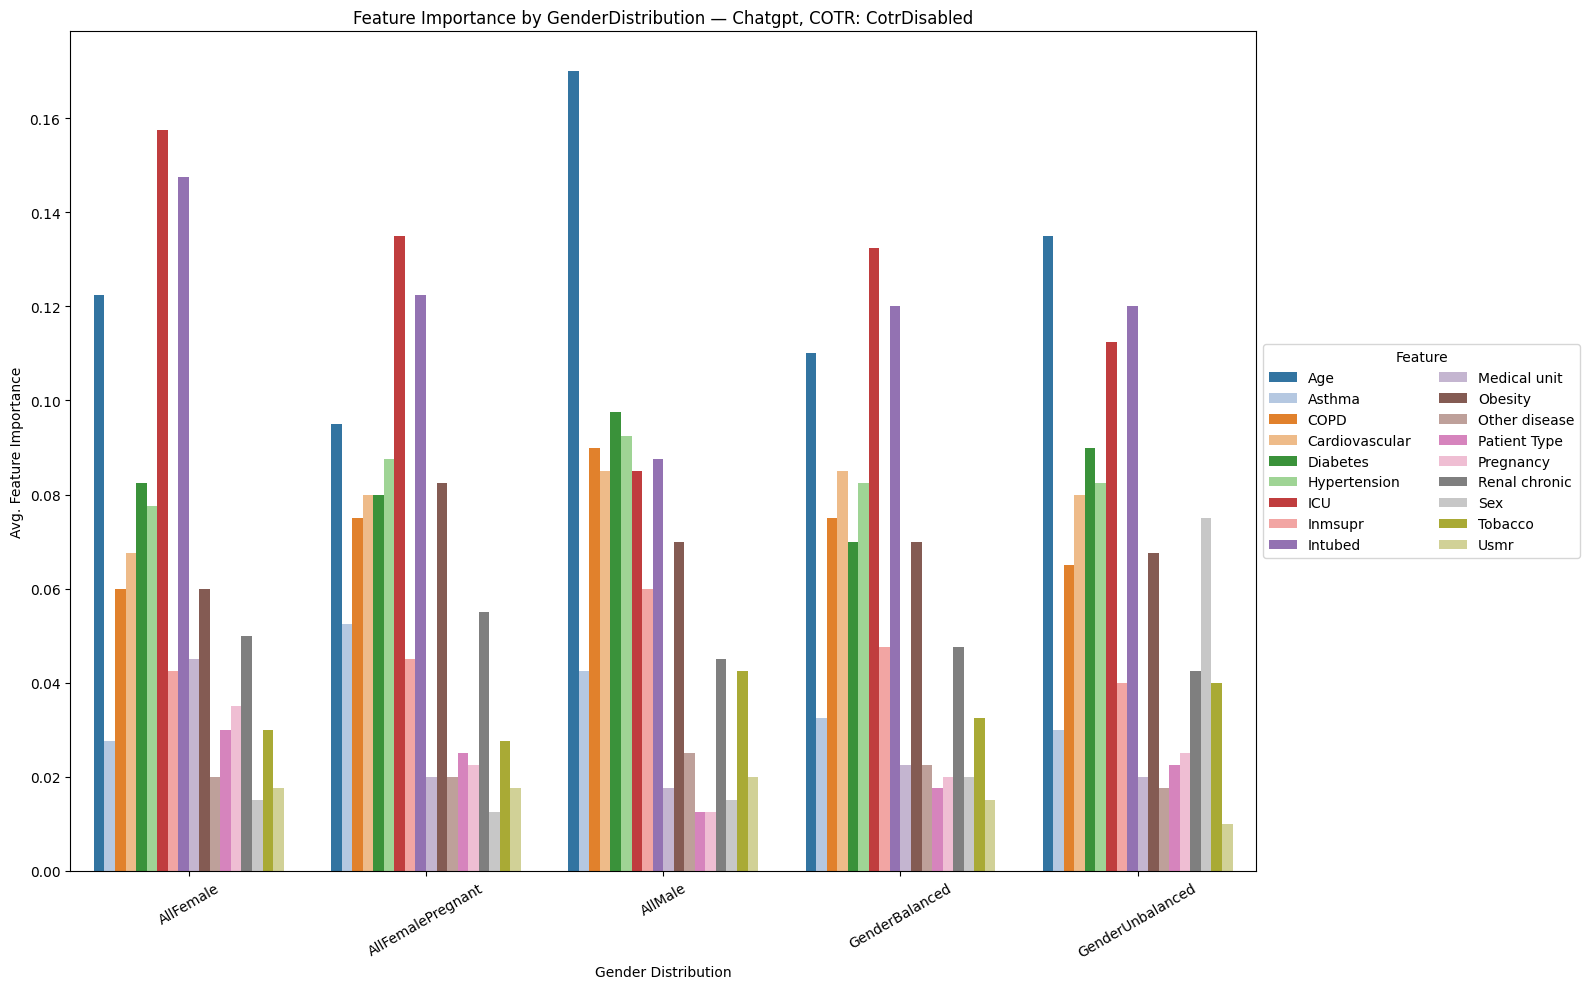

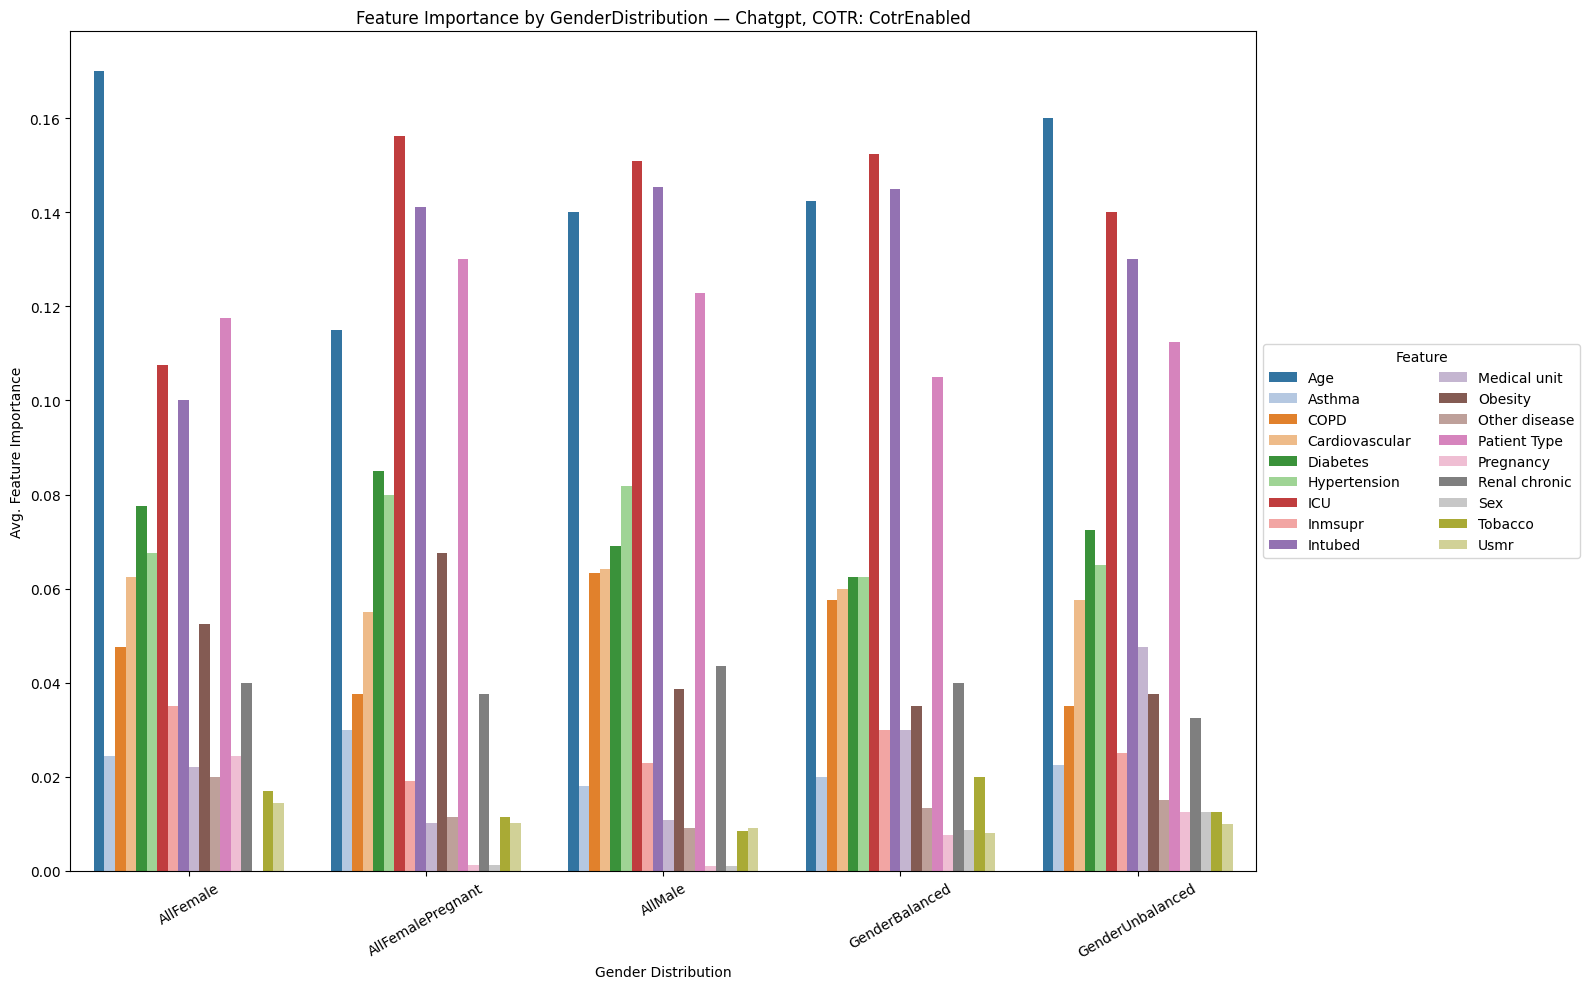

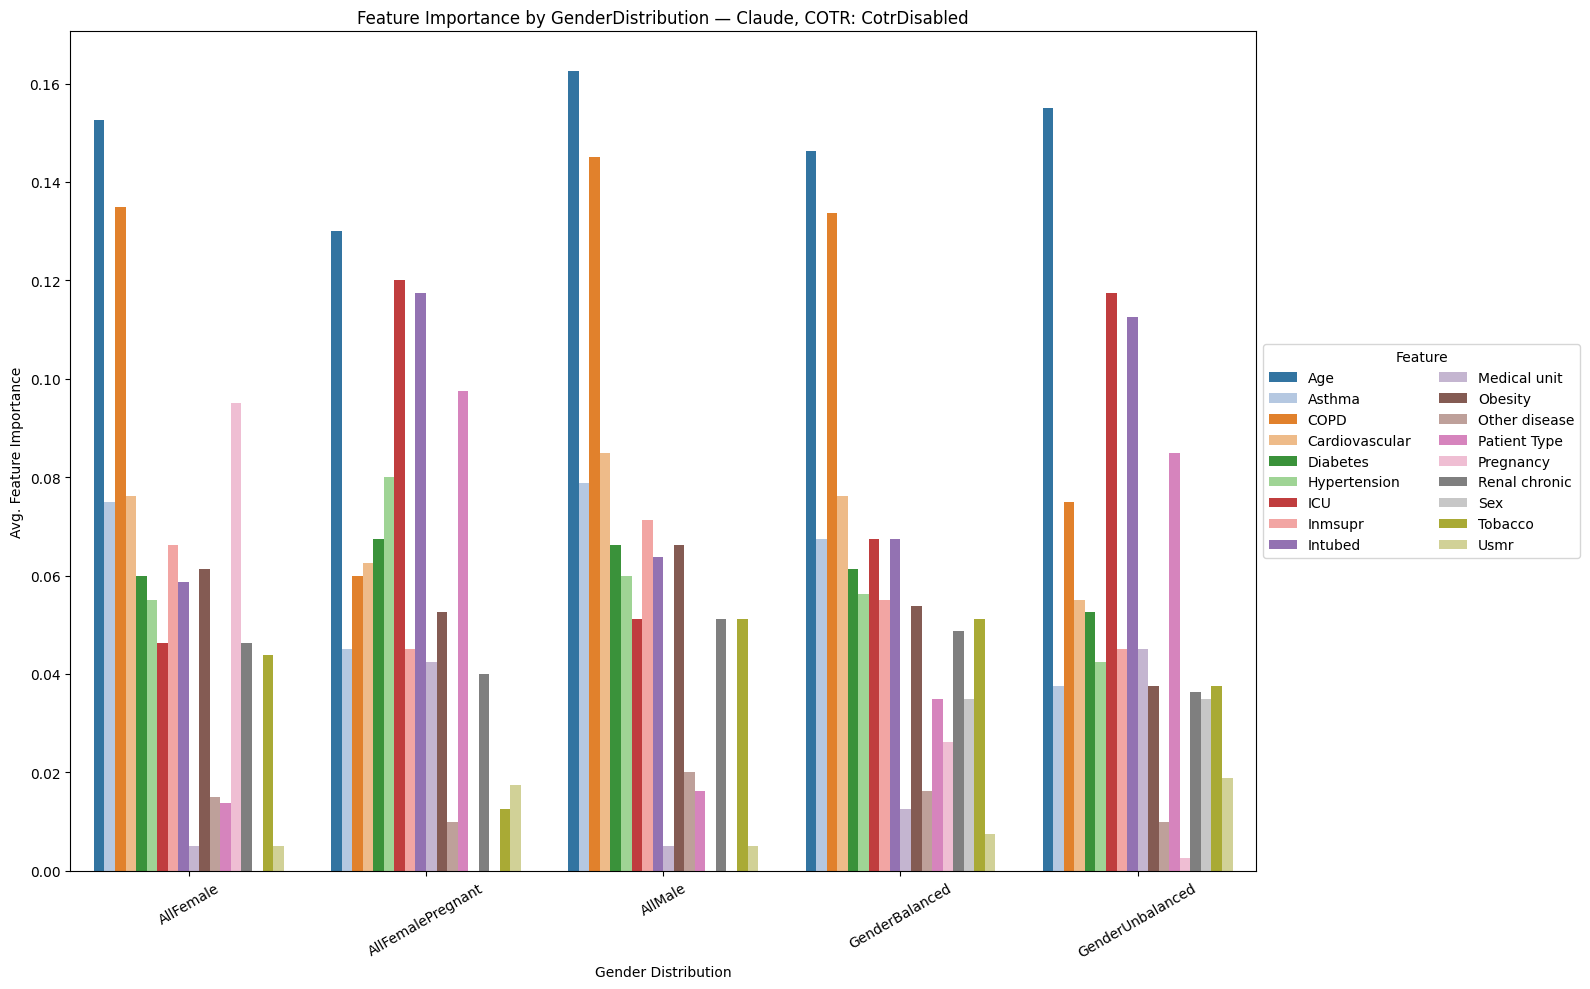

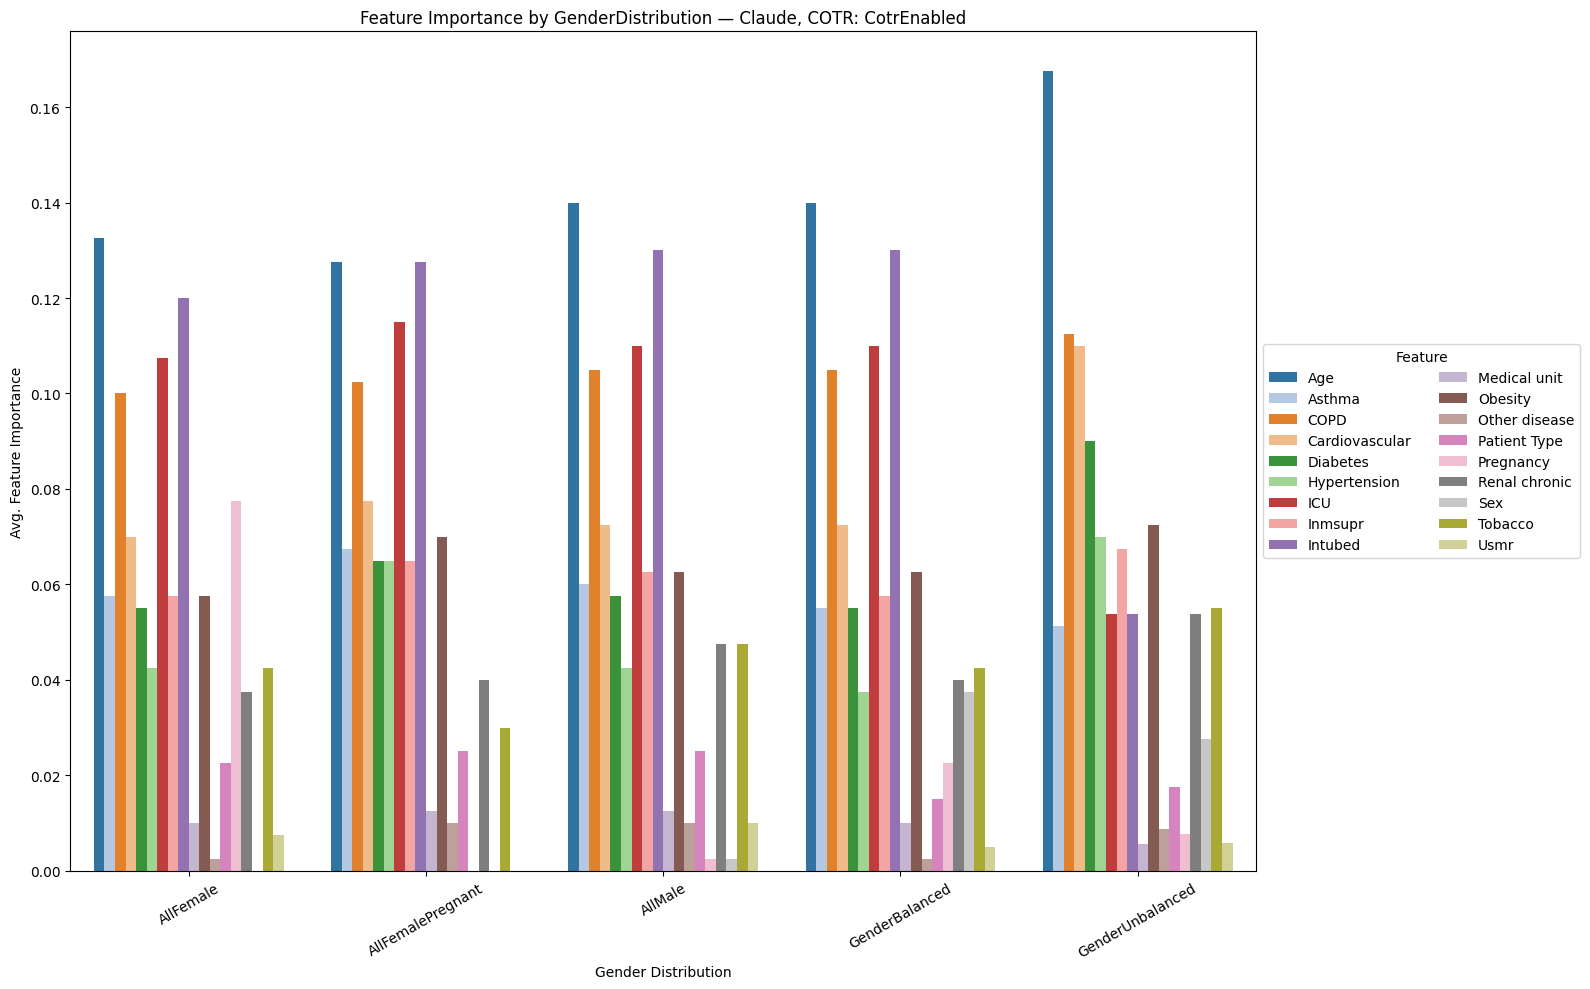

All 6 plots saved to: output_gender_feature_barplots_v2


In [21]:
# Create output folder !!
output_dir = "output_gender_feature_barplots_v2"
os.makedirs(output_dir, exist_ok=True)

# Ensure consistent ordering
feature_order = sorted(df["Feature"].unique())
gender_order = ["AllFemale", "AllFemalePregnant", "AllMale", "GenderBalanced", "GenderUnbalanced"]

#Incorporate a more distinct color palette (previous one lacked contrast)
palette = sns.color_palette("tab20", len(feature_order))

# Loop over LLM × COTR
for llm in df["LLM"].unique():
    for cotr in df["COTR"].unique():
        # Subset data
        subset = df[(df["LLM"] == llm) & (df["COTR"] == cotr)]

        # Group: gender + feature → avg importance
        grouped = (
            subset.groupby(["GenderDistribution", "Feature"])["Importance"]
            .mean()
            .reset_index()
        )

        # Plot
        plt.figure(figsize=(16, 10))
        sns.barplot(
            data=grouped,
            x="GenderDistribution",
            y="Importance",
            hue="Feature",
            order=gender_order,
            hue_order=feature_order,
            palette=palette
        )

        plt.title(f"Feature Importance by GenderDistribution — {llm}, COTR: {cotr}")
        plt.ylabel("Avg. Feature Importance")
        plt.xlabel("Gender Distribution")
        plt.xticks(rotation=30)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Feature", ncol=2)
        plt.tight_layout()

        # Save
        filename = f"{llm}_{cotr}_GroupedByGender_X_Gender_Y_Importance.png".replace(" ", "_")
        plt.savefig(os.path.join(output_dir, filename))
        plt.show()
        plt.close()

print("All 6 plots saved to:", output_dir)

### Average Feature Importance for TOP 5 Features Across Gender Distributions, LLM, and COTR

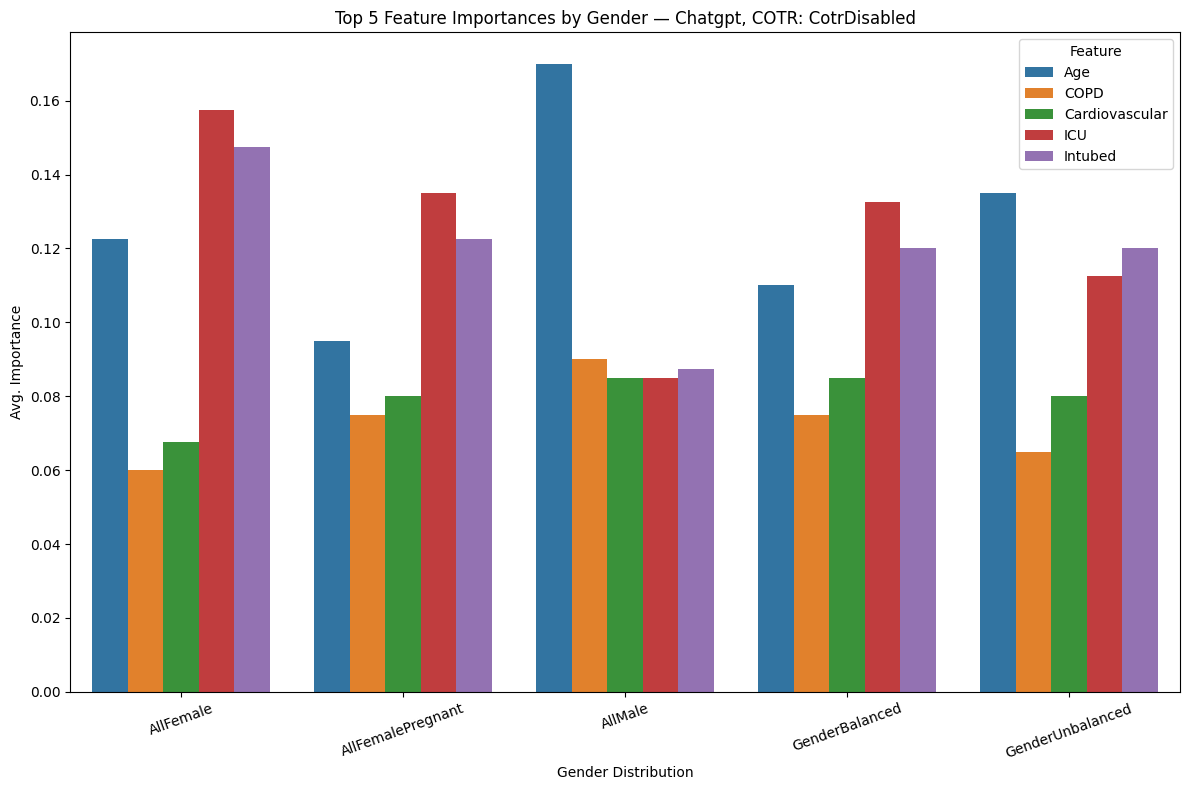

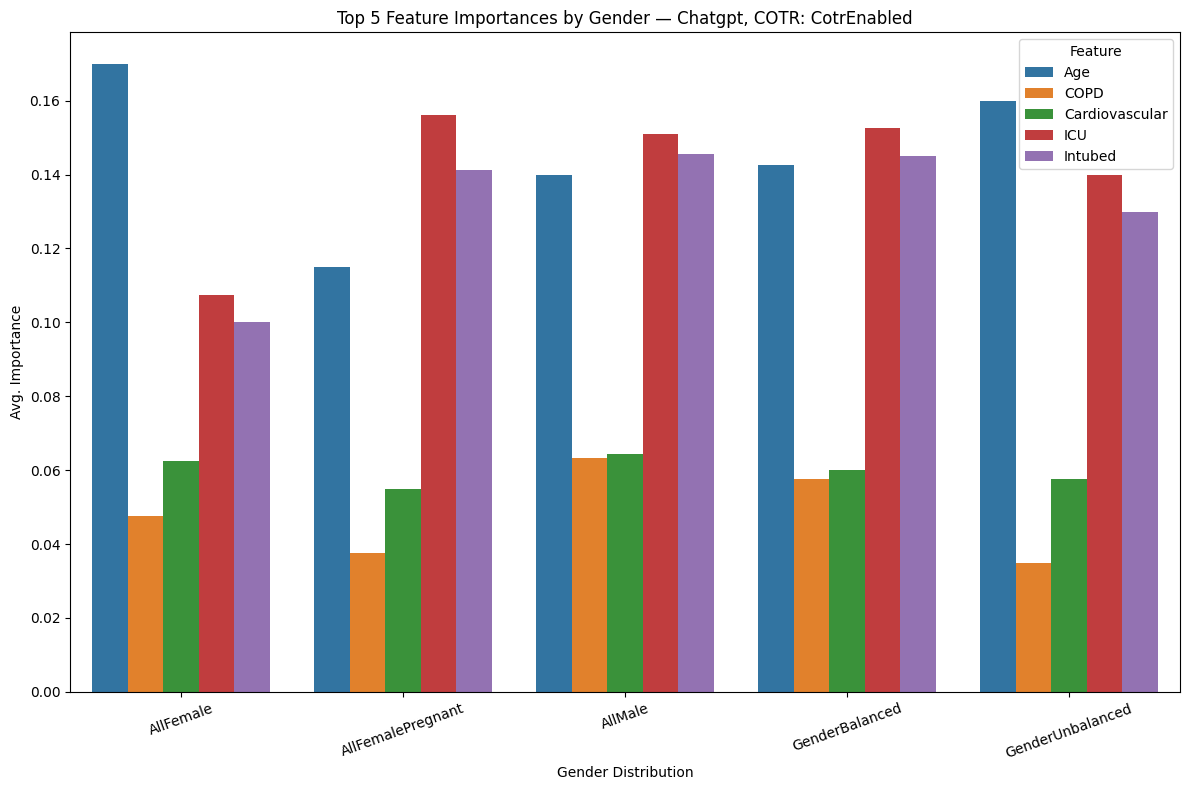

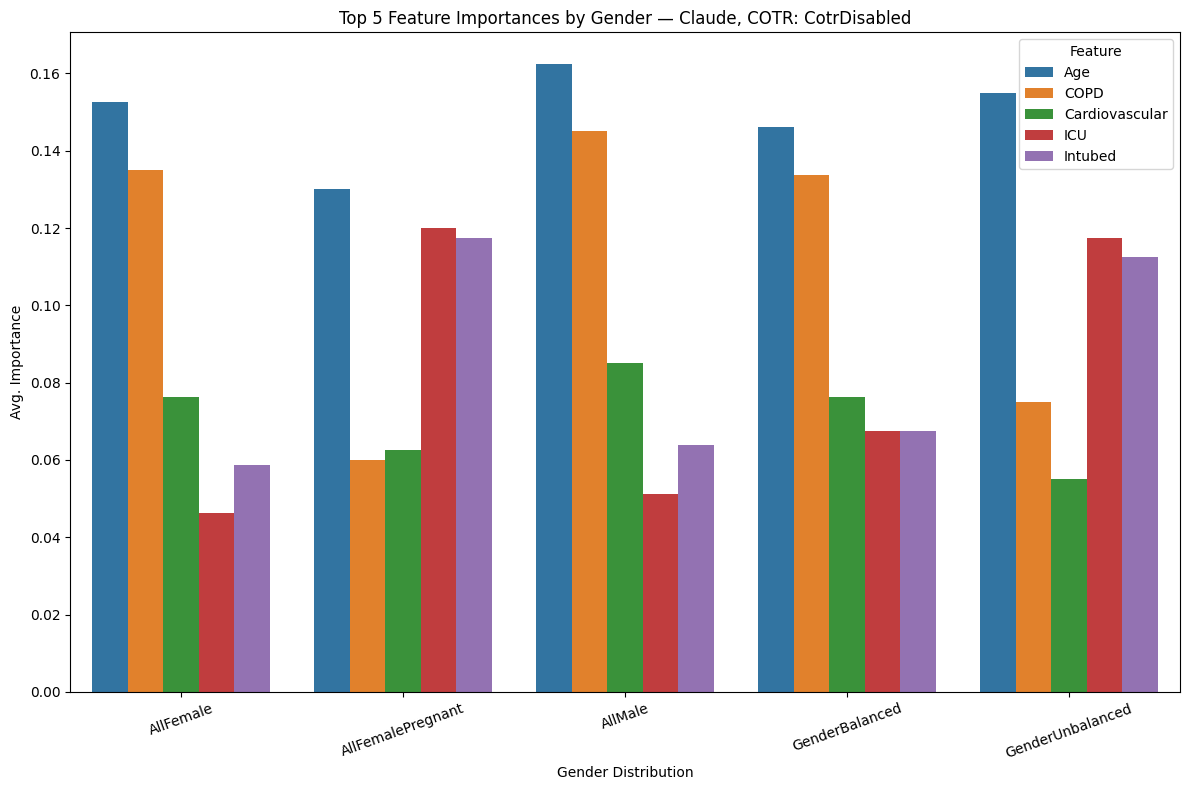

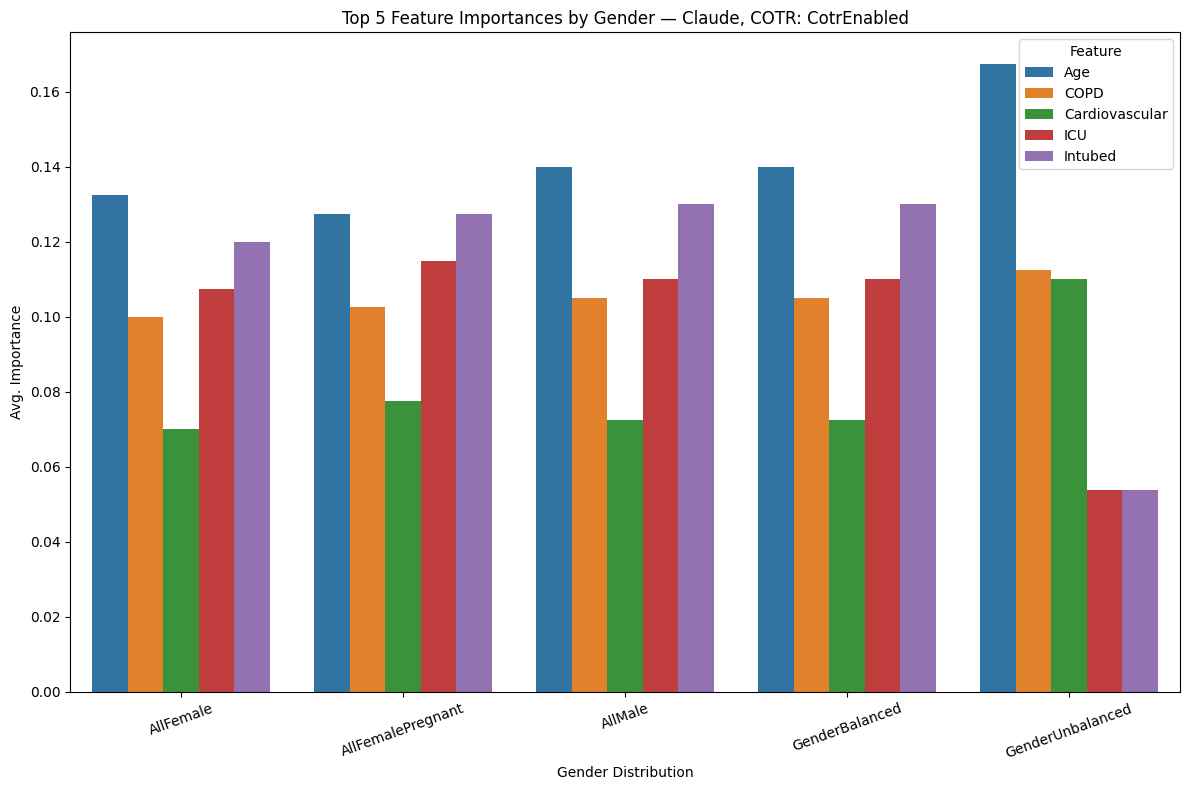

Top 5 feature barplots saved to: output_gender_feature_barplots_v2


In [ ]:
top_features = ["Age", "Intubed", "ICU", "COPD", "Cardiovascular"]

# Loop over LLM x COTR
for llm in df["LLM"].unique():
    for cotr in df["COTR"].unique():
        # Subset relevant data
        subset = df[(df["LLM"] == llm) & (df["COTR"] == cotr) & (df["Feature"].isin(top_features))]

        # Group by gender + feature → average importance
        grouped = (
            subset.groupby(["GenderDistribution", "Feature"])["Importance"]
            .mean()
            .reset_index()
        )

        # Plot
        plt.figure(figsize=(12, 8))
        sns.barplot(
            data=grouped,
            x="GenderDistribution",
            y="Importance",
            hue="Feature",
            order=["AllFemale", "AllFemalePregnant", "AllMale", "GenderBalanced", "GenderUnbalanced"]
        )
        plt.title(f"Top 5 Feature Importances by Gender — {llm}, COTR: {cotr}")
        plt.ylabel("Avg. Importance")
        plt.xlabel("Gender Distribution")
        plt.xticks(rotation=20)
        plt.legend(title="Feature")
        plt.tight_layout()

        # Save
        filename = f"{llm}_{cotr}_Top5FeatureBarplot.png".replace(" ", "_")
        plt.savefig(os.path.join(output_dir, filename))
        plt.show()
        plt.close()

print("Top 5 feature barplots saved to:", output_dir)

### Feature Importance Comparison by LLM given TARGET VALUE, GENDER DIST

In [26]:
#LLM Comparison Barplot
def plot_llm_comparison(target_col, gender_dist):
    subset = df[(df["Target Value"] == target_col) & (df["GenderDistribution"] == gender_dist)]
    plt.figure(figsize=(14, 6))
    sns.barplot(data=subset, x="Feature", y="Importance", hue="LLM")
    plt.title(f"Feature Importance by LLMs — Target Value: {target_col}, Gender: {gender_dist}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

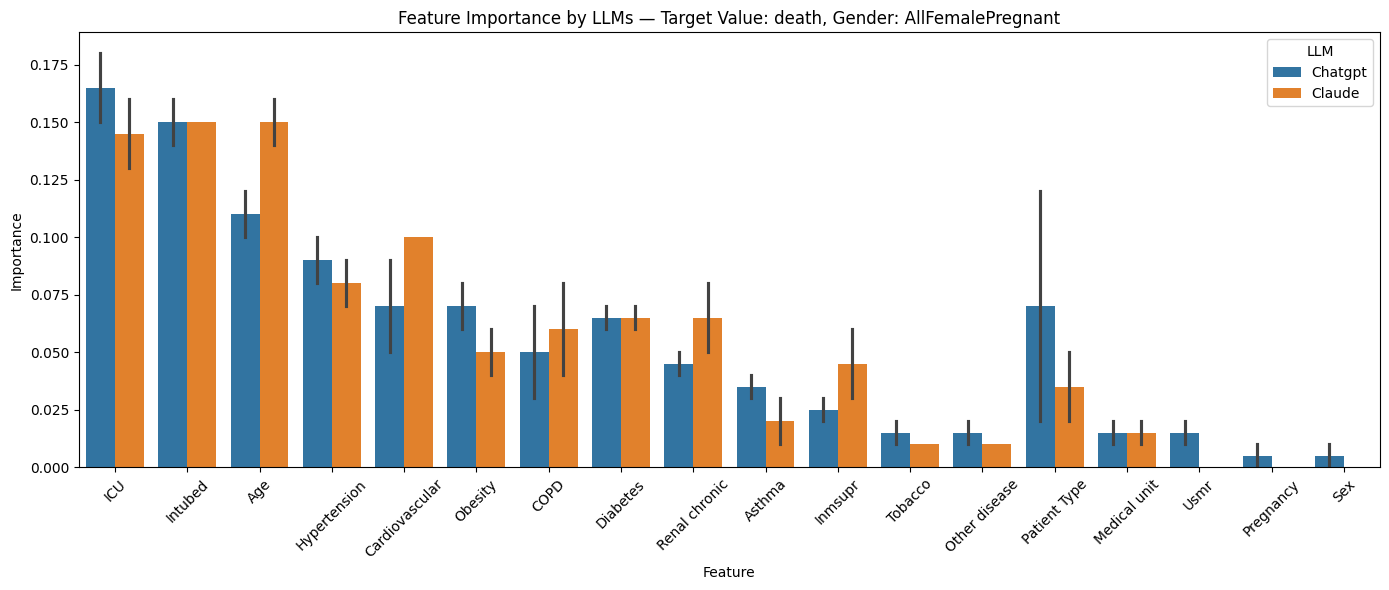

In [27]:
# Takes arguments: (Feature Value, Gender Distribution), plots as bar graph
#(lowercase wording require for ALL FEATURE VALUES)
plot_llm_comparison("death", "AllFemalePregnant") 



### COTR Comparison by LLM given FEATURE, TARGET VALUE

In [28]:
# COTR Comparison for Specific Feature
def plot_cotr_comparison(feature, target_col):
    subset = df[(df["Feature"] == feature) & (df["Target Value"] == target_col)]
    sns.boxplot(data=subset, x="COTR", y="Importance", hue="LLM")
    plt.title(f"Effect of COTR on Feature '{feature}' Importance — Target: {target_col}")
    plt.tight_layout()
    plt.show()

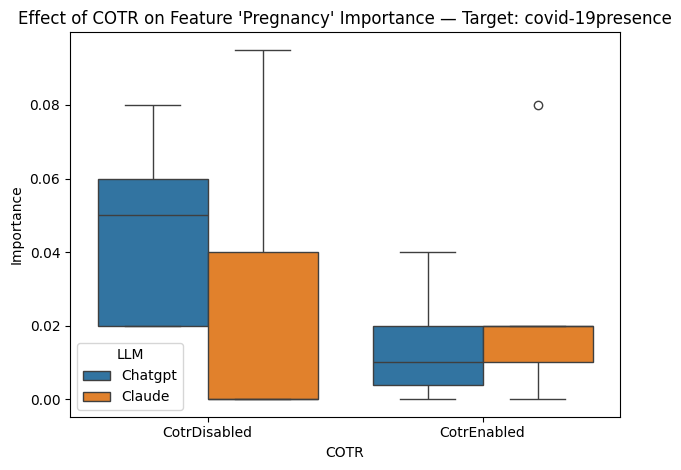

In [29]:
# Takes arguments: (Feature Value, Gender Distribution) and plots as bar graph
# feature needs to be LOWERCASE to adjust to data normalization
# for naming discrepancy
plot_cotr_comparison("Pregnancy", "covid-19presence")

In [30]:
# bubble chart representation (just playing around)
fig = px.scatter(df,
                 x="Feature", y="Importance",
                 color="LLM",
                 size="Importance",
                 facet_col="Target Value",
                 facet_row="GenderDistribution",
                 hover_data=["COTR"])
fig.update_layout(title="Feature Importance Visualization")
fig.show()